# Cardiovascular Disease Prediction

## 1. Imports

In [30]:
# all imports, turn off warnings, display always all columns

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, recall_score
from scikitplot.metrics import plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## 2. Load data + data cleaning and transformation

In [3]:
# read the dataset from csv file and have a first rough look at it
df = pd.read_csv('data/cardio_train.csv', sep = ';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
# I have age in days, I change it to years and put it to a new column and I drop the original column for age in days, I also drop the column id, I do not need it for prediction purposes
df['age_years']=df['age']//365
df.drop(columns = ['age', 'id'],inplace = True)

# I create a new column with BMI
df['bmi'] = (df['weight']/((df['height']/100)**2)).round(2)

# I create a new column with the difference (gap) between higher and lower blood preasure value
df['bp_gap'] = df['ap_hi'] - df['ap_lo']
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_gap
0,2,168,62.0,110,80,1,1,0,0,1,0,50,21.97,30
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.93,50
2,1,165,64.0,130,70,3,1,0,0,0,1,51,23.51,60
3,2,169,82.0,150,100,1,1,0,0,1,1,48,28.71,50
4,1,156,56.0,100,60,1,1,0,0,0,0,47,23.01,40


In [5]:
# Let's check the statistics of numerical values
df.describe()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_gap
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,52.840671,27.556545,32.186871
std,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.766774,6.091405,241.469638
min,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000,3.470000,-10800.000000
25%,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000,23.880000,40.000000
50%,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000,26.375000,40.000000
75%,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,30.220000,50.000000
max,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000,298.670000,15940.000000


In [6]:
# I can see some problems above - e. g. max and min weight and height, which does not correspond to the age range from 29 up to 64 years
# There are some problems with min and max blood presure values
# I try to fix all these problems by dropping heights, weights, ap_hi and ap_lo that fall below 2.5% or above 97.5% of a given range

df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)

df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

# Check, if lower blood preasure values is always lower than the higher preasure value (otherwise it is a mistake) - looks OK
df[df['ap_lo']> df['ap_hi']].shape[0]

0

In [7]:
# Here we can see that the cleaned data set has 60142 entries, all features are numerical (no NaN and null values)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60142 entries, 0 to 69999
Data columns (total 14 columns):
gender         60142 non-null int64
height         60142 non-null int64
weight         60142 non-null float64
ap_hi          60142 non-null int64
ap_lo          60142 non-null int64
cholesterol    60142 non-null int64
gluc           60142 non-null int64
smoke          60142 non-null int64
alco           60142 non-null int64
active         60142 non-null int64
cardio         60142 non-null int64
age_years      60142 non-null int64
bmi            60142 non-null float64
bp_gap         60142 non-null int64
dtypes: float64(2), int64(12)
memory usage: 6.9 MB


In [8]:
# There is one more thing to solve, to determine, which gender stands for values 1 and 2, so let's have a look at the statistics separately for gender 1 and 2
df.loc[(df['gender']==1),:].describe()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_gap
count,39254.0,39254.000000,39254.000000,39254.000000,39254.000000,39254.000000,39254.000000,39254.000000,39254.000000,39254.0000,39254.000000,39254.000000,39254.000000,39254.000000
mean,1.0,162.055434,72.335061,125.327865,80.752204,1.371478,1.230117,0.016890,0.024787,0.8016,0.489988,52.961915,27.617201,44.575661
std,0.0,5.983263,11.588933,13.875796,8.307237,0.685681,0.579773,0.128861,0.155478,0.3988,0.499906,6.632040,4.691702,9.995098
min,1.0,150.000000,52.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.0000,0.000000,29.000000,16.410000,9.000000
25%,1.0,158.000000,64.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.0000,0.000000,49.000000,23.990000,40.000000
50%,1.0,162.000000,70.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.0000,0.000000,54.000000,26.640000,40.000000
75%,1.0,166.000000,80.000000,130.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.0000,1.000000,58.000000,30.480000,50.000000
max,1.0,180.000000,106.000000,163.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.0000,1.000000,64.000000,46.670000,100.000000


In [9]:
df.loc[(df['gender']==2),:].describe()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_gap
count,20888.0,20888.000000,20888.000000,20888.000000,20888.000000,20888.000000,20888.000000,20888.000000,20888.000000,20888.000000,20888.000000,20888.000000,20888.000000,20888.000000
mean,2.0,169.251915,75.478476,126.602403,81.599004,1.312380,1.201647,0.214812,0.102786,0.807497,0.484920,52.610781,26.331534,45.003399
std,0.0,5.765715,11.383710,13.506249,8.080961,0.637955,0.543535,0.410702,0.303687,0.394275,0.499784,6.955321,3.662033,9.932927
min,2.0,150.000000,52.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000,16.050000,0.000000
25%,2.0,165.000000,68.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,47.000000,23.740000,40.000000
50%,2.0,170.000000,74.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000,25.730000,40.000000
75%,2.0,174.000000,83.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,28.580000,50.000000
max,2.0,180.000000,106.000000,163.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000,43.110000,100.000000


In [10]:
# According to statistics above (mainly height and weight) I assume, that value 1 stands for women and value 2 stands for men, I rather transform these values to 0 (men) / 1 (women) form
df['gender'] = df.gender.map({1 : 1, 2 : 0})

In [11]:
# Final prepared dataset
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_gap
0,0,168,62.0,110,80,1,1,0,0,1,0,50,21.97,30
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.93,50
2,1,165,64.0,130,70,3,1,0,0,0,1,51,23.51,60
3,0,169,82.0,150,100,1,1,0,0,1,1,48,28.71,50
4,1,156,56.0,100,60,1,1,0,0,0,0,47,23.01,40


## 3. Exploratory data analysis

In [12]:
# Almost one half of the observed people were diagnosed with CVD
df['cardio'].value_counts()

0    30779
1    29363
Name: cardio, dtype: int64

In [13]:
# Almost 2/3 of all diagnosed are women
df.groupby('gender')['cardio'].agg(sum)

gender
0    10129
1    19234
Name: cardio, dtype: int64

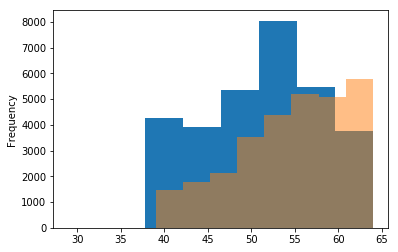

In [14]:
# The amount of people diagnosed with CVD raise with the age
df['age_years'][df.cardio == 0].plot(kind='hist', bins=8)
df['age_years'][df.cardio == 1].plot(kind='hist', bins=8, alpha=.5)

In [15]:
# I create new subsets with all diagnosed and not diagnosed with CVD
df_cardio = df.loc[(df['cardio'] == 1), :]
df_not_cardio = df.loc[(df['cardio'] == 0), :]

In [16]:
# Let's have a look at the level of cholesterol and the chance to get diagnosed with CVD
cardio_chol1 = (df_cardio['cholesterol']==1).sum()/(df['cholesterol']==1).sum()*100
cardio_chol2 = (df_cardio['cholesterol']==2).sum()/(df['cholesterol']==2).sum()*100
cardio_chol3 = (df_cardio['cholesterol']==3).sum()/(df['cholesterol']==3).sum()*100

print('If your cholesterol is normal (value 1), your probability to be diagnosed with CVS is ' + str(round(cardio_chol1)) + '%.')
print('If your cholesterol is above normal (value 2), your probability to be diagnosed with CVS is ' + str(round(cardio_chol2)) + '%.')
print('If your cholesterol is well above normal (value 3), your probability to be diagnosed with CVS is ' + str(round(cardio_chol3)) + '%.')

If your cholesterol is normal (value 1), your probability to be diagnosed with CVS is 43.0%.
If your cholesterol is above normal (value 2), your probability to be diagnosed with CVS is 59.0%.
If your cholesterol is well above normal (value 3), your probability to be diagnosed with CVS is 76.0%.


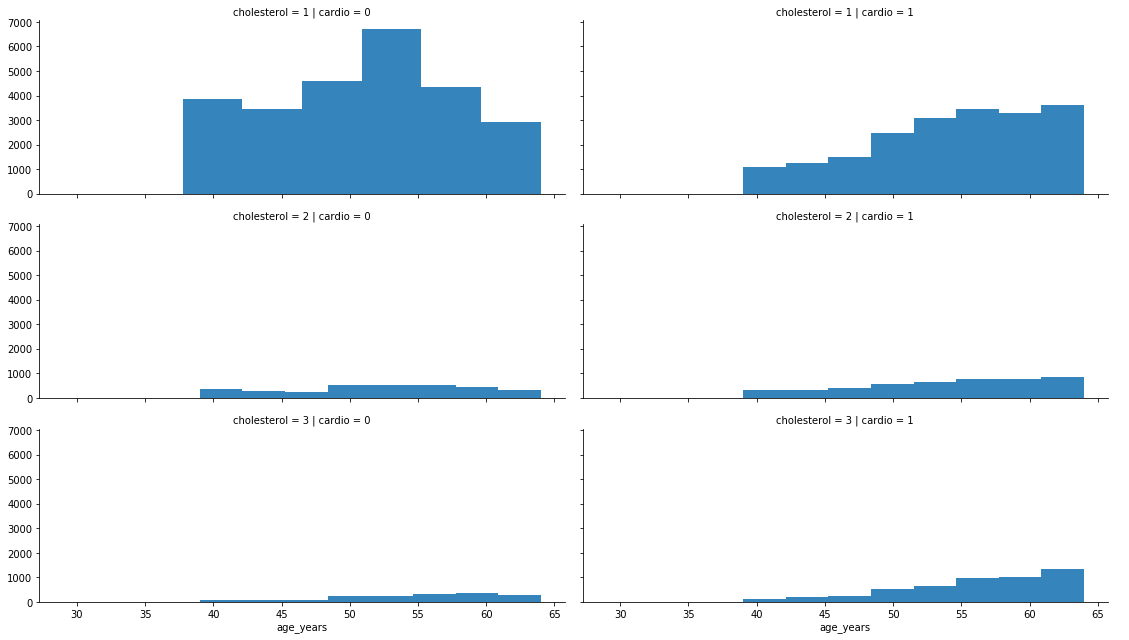

In [17]:
# Let's have a look at the level of cholesterol and the chance to get diagnosed with CVD - now on a graph
grid = sns.FacetGrid(data=df, col='cardio', row='cholesterol', size=3, aspect=2.6)
grid.map(plt.hist, 'age_years', alpha=.9, bins=8)
grid.add_legend();

In [18]:
# Let's have a look at the level of glucose and the chance to get diagnosed with CVD
cardio_gluc1 = (df_cardio['gluc']==1).sum()/(df['gluc']==1).sum()*100
cardio_gluc2 = (df_cardio['gluc']==2).sum()/(df['gluc']==2).sum()*100
cardio_gluc3 = (df_cardio['gluc']==3).sum()/(df['gluc']==3).sum()*100

print('If your glucose is normal (value 1), your probability to be diagnosed with CVS is ' + str(round(cardio_gluc1)) + '%.')
print('If your glucose is above normal (value 2), your probability to be diagnosed with CVS is ' + str(round(cardio_gluc2)) + '%.')
print('If your glucose is well above normal (value 3), your probability to be diagnosed with CVS is ' + str(round(cardio_gluc3)) + '%.')

If your glucose is normal (value 1), your probability to be diagnosed with CVS is 47.0%.
If your glucose is above normal (value 2), your probability to be diagnosed with CVS is 57.0%.
If your glucose is well above normal (value 3), your probability to be diagnosed with CVS is 61.0%.


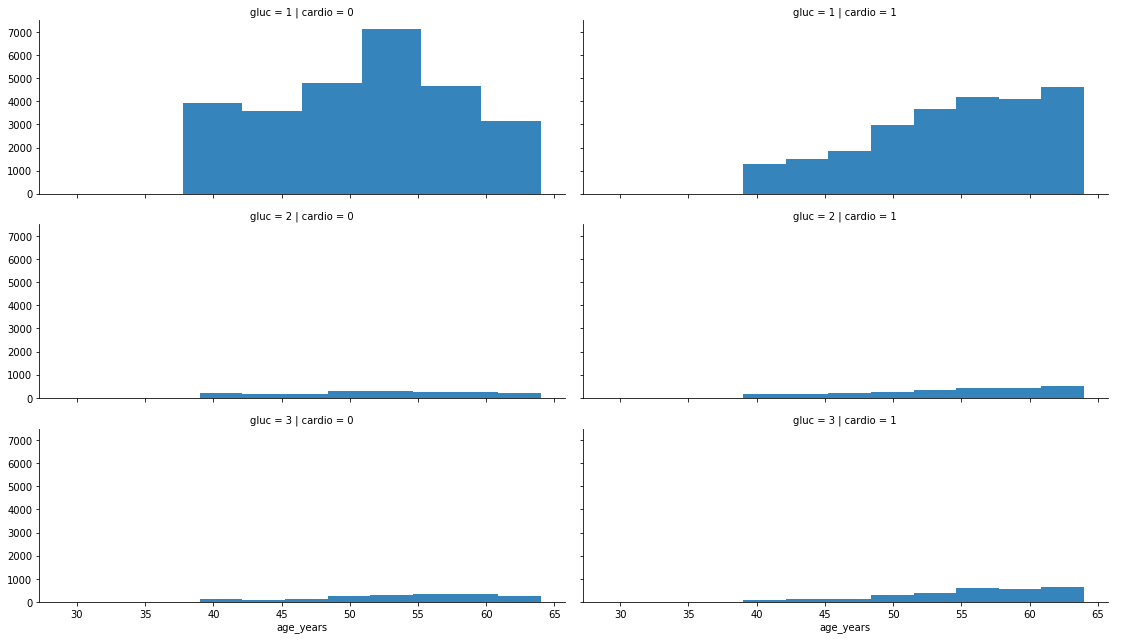

In [19]:
# Let's have a look at the level of glucose and the chance to get diagnosed with CVD - now on a graph - we can see that the situation is simmilar as with cholesterol
grid = sns.FacetGrid(data=df, col='cardio', row='gluc', size=3, aspect=2.6)
grid.map(plt.hist, 'age_years', alpha=.9, bins=8)
grid.add_legend();

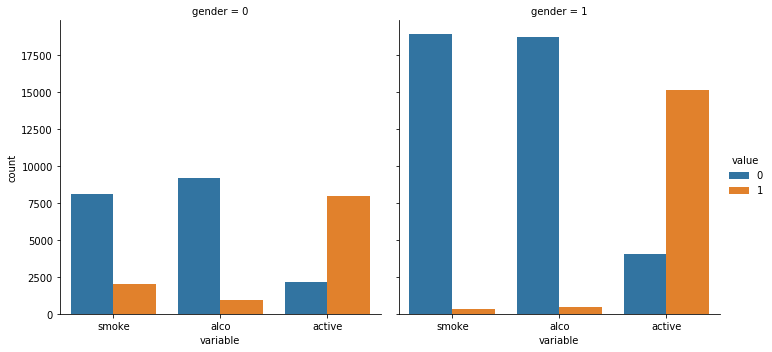

In [20]:
# Let's have a look at variables smoke, alco and active, first we look at people diagnosed with CVD
data1 = pd.melt(df_cardio, id_vars=['gender'], value_vars=['smoke', 'alco', 'active'])
sns.catplot(x= "variable", hue="value", col="gender", data=data1, kind="count");

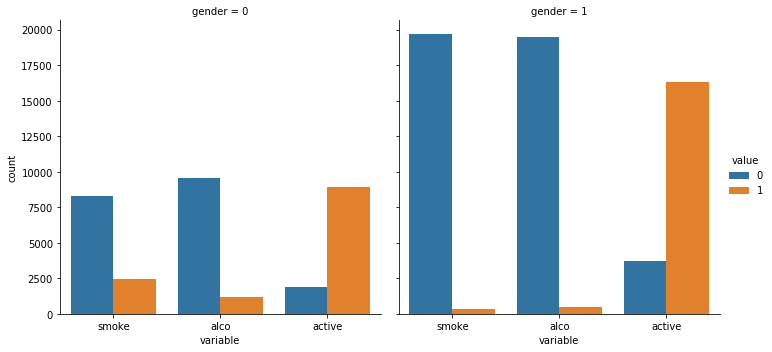

In [21]:
# Now we have a look at people not diagnosed with CVD - we can see, that woman smoke and drink less and are more active than men 
# And also we can see that there is no siginificantly higher probabiltiy to get diagnosed with CVD when one drink, smoke or is not active (looks like these are not the main reasons)
data2 = pd.melt(df_not_cardio, id_vars=['gender'], value_vars=['smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="gender", data=data2, kind="count");

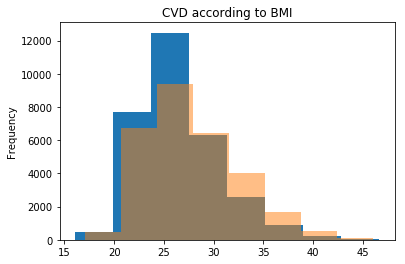

In [22]:
# Let's have a look at the BMI - we can see that with higher BMI is also the chance to get diagnosed with CVD higher
df['bmi'][df.cardio == 0].plot(kind='hist', bins=8)
df['bmi'][df.cardio == 1].plot(kind='hist', bins=8, alpha=.5, title="CVD according to BMI")

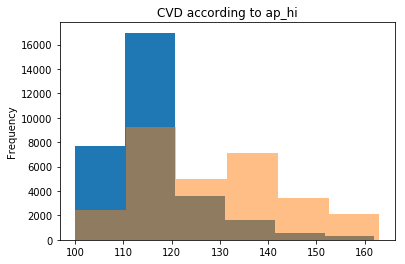

In [23]:
# How about the blood preasure? First let's have a look at the higher blood preasure value. The higher it is - the higher is the chance to get diagnosed with CVD
df['ap_hi'][df.cardio == 0].plot(kind='hist', bins=6)
df['ap_hi'][df.cardio == 1].plot(kind='hist', bins=6, alpha=.5, title="CVD according to ap_hi")

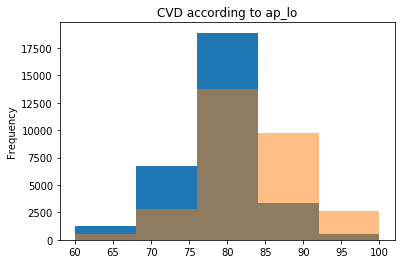

In [24]:
# How about the lower blood preasure value? The higher is also this one - the higher is the chance to get diagnosed with CVD as well
df['ap_lo'][df.cardio == 0].plot(kind='hist', bins=5)
df['ap_lo'][df.cardio == 1].plot(kind='hist', bins=5, alpha=.5, title="CVD according to ap_lo")

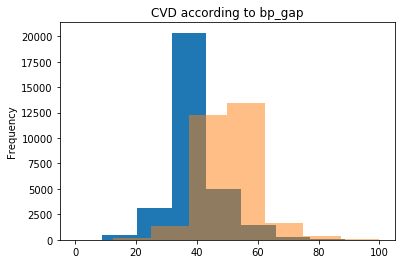

In [25]:
# And how about the gap between these two values? It looks like the higher the gap is - the higher is the chance to get diagnosed with CVD
df['bp_gap'][df.cardio == 0].plot(kind='hist', bins=8)
df['bp_gap'][df.cardio == 1].plot(kind='hist', bins=8, alpha=.5, title="CVD according to bp_gap")

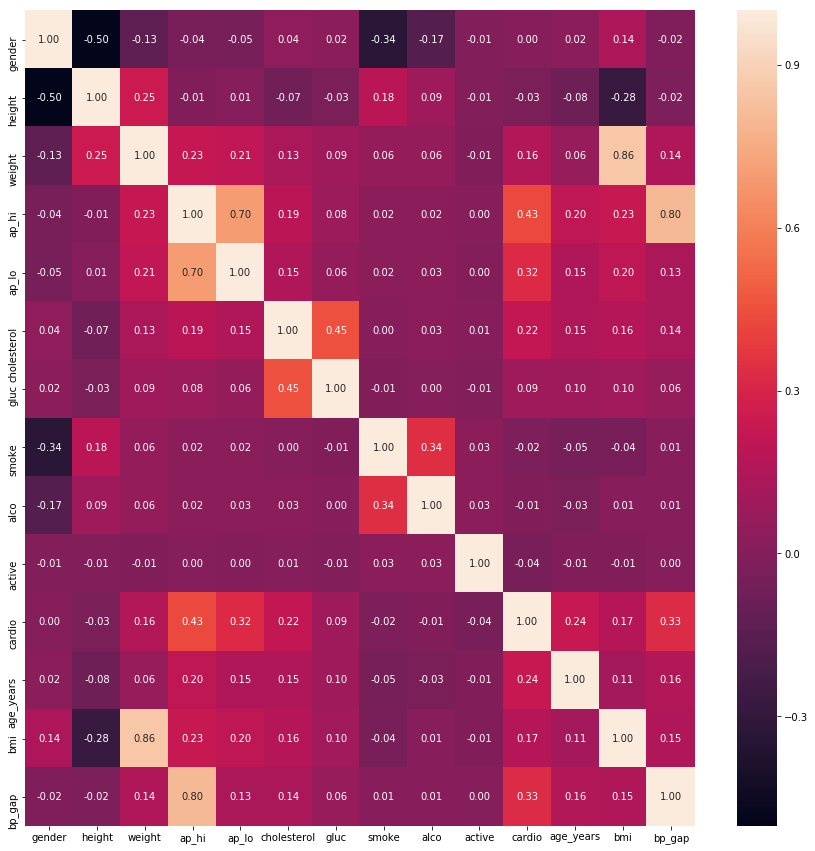

In [26]:
# Now let's have a look at the correlation matrix between all features
corr_data = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_data, annot=True, fmt = ".2f")
plt.show()

In [27]:
# We can see the correlation between derived features and it's entry values - eg. bp_gap and ap_hi, bmi and weight
# We can similar correlations between weight and ap_lo and ap_hi and maybe as we would expect, the correlation between features smoke and alco :)
# We can see also the correlation between level of glucose and cholesterol
# Ap_hi, bp_gap, age and cholesterol look like the main features influencing the probability to get diagnosed with CVD

In [28]:
# I am curious about the differences in correlations among men and women, so I create new subsets for men and women
df_men = df.loc[(df['gender'] == 0), :]
df_women = df.loc[(df['gender'] == 1), :]

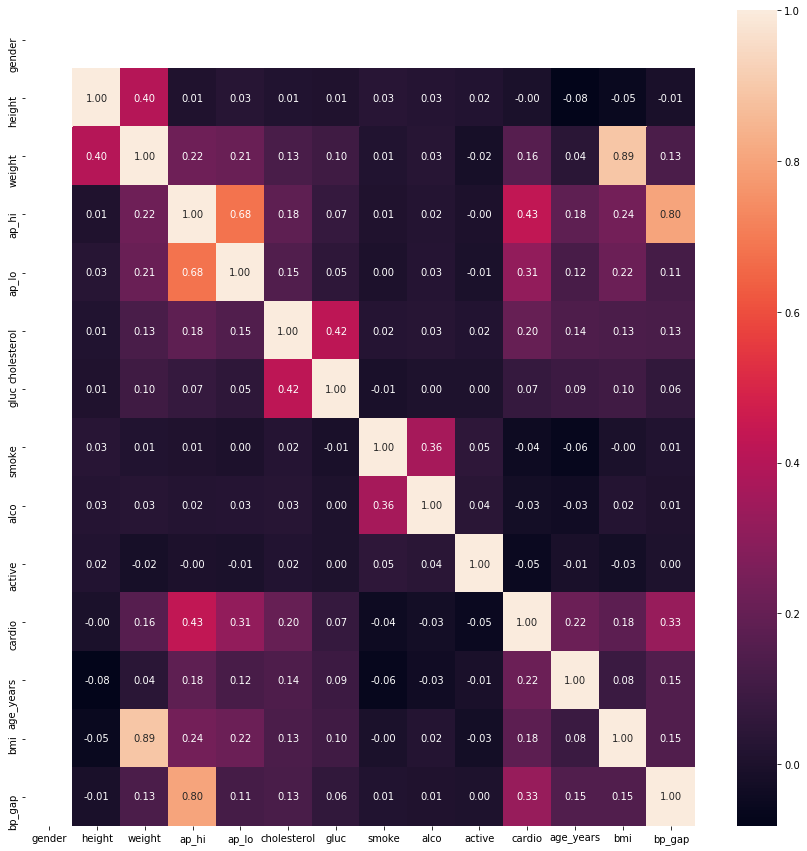

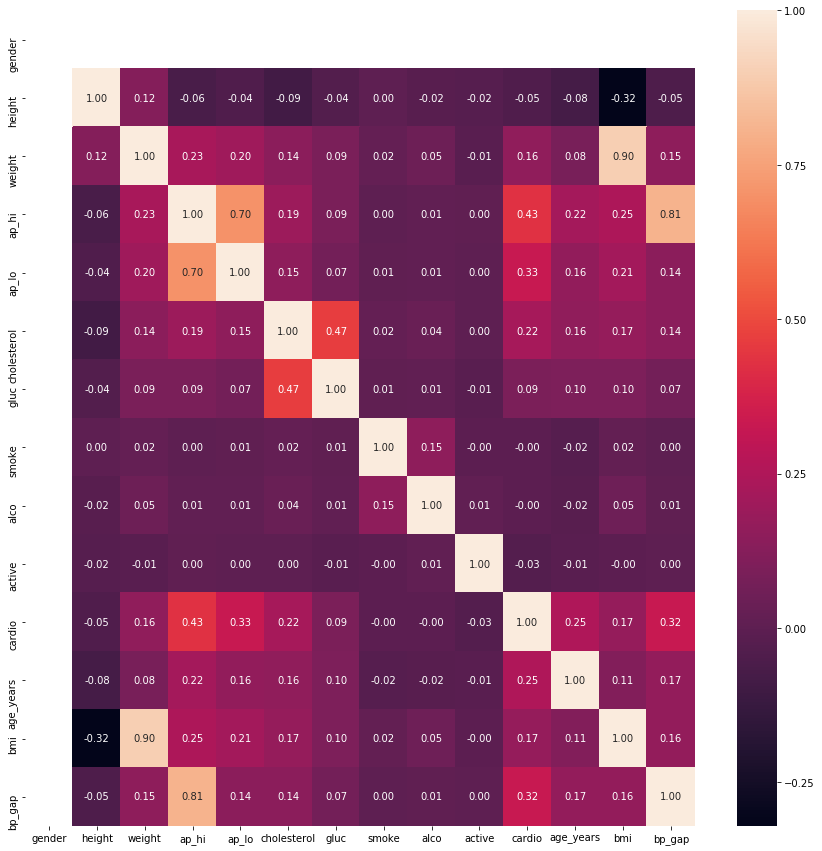

In [29]:
# Now let's have a look at the correlation matrix among men and then amon women
corr_data = df_men.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_data, annot=True, fmt = ".2f")
plt.show()

corr_data = df_women.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_data, annot=True, fmt = ".2f")
plt.show()

# 4. Machine Learning Modelling

## 4.1 Prepare train and test datasets, definitions

In [38]:
X = df.drop('cardio', axis=1)
y = df['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=88)

# DEFINITIONS

# function for class predicting based on model
def predict_class(model, x_test):
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:,1]
    
    return y_pred, y_prob

# predict and print report
def show_summary(model, x_test, y_test):

    y_pred, y_prob = predict_class(model, x_test)

    model.report = classification_report(y_test, y_pred, target_names=["no","yes"])
    print(model.report)

# plot confusion table and ROC curve
def plot_conf_ROC(model, x_test, y_test):
    
    # calculate class predictions and probabilities
    y_pred, y_prob = predict_class(model, x_test)
    
    # accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # recall 
    recall = recall_score(y_test, y_pred)

    # confusion matrix
    conf = confusion_matrix(y_test, y_pred)

    # visualize conf table and ROC curve
    plt.figure(figsize=(14,7))

    plt.subplot(121)
    sns.heatmap(conf, annot=True, fmt=".0f", linewidths=.5, square = True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Recall Score: {0:.2f}%'.format(100*recall)
    plt.title(all_sample_title, size = 15)

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    plt.subplot(122)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title('ROC curve (AUC = {0:.2f}%)'.format(100*auc_score))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

## 4.2 KNN

KNN accuracy: 0.6650375371592684, AUC: 0.6646584960596427
              precision    recall  f1-score   support

          no       0.66      0.69      0.68     10051
         yes       0.67      0.64      0.65      9796

   micro avg       0.67      0.67      0.67     19847
   macro avg       0.67      0.66      0.66     19847
weighted avg       0.67      0.67      0.66     19847



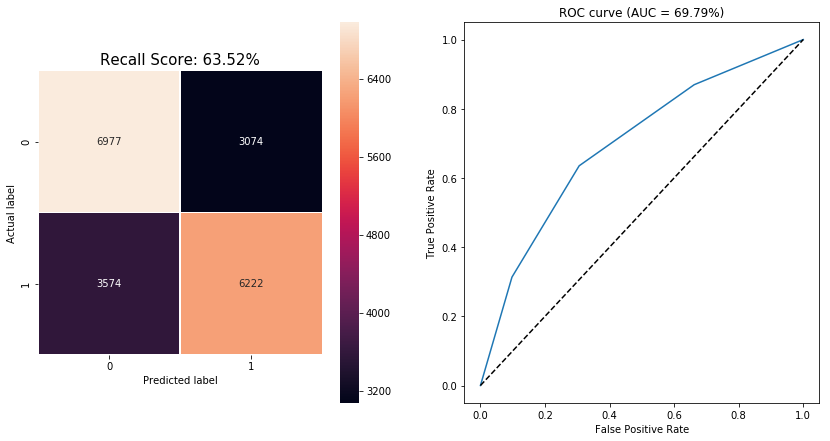

In [42]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

# KNN performance
accuracy = knn.score(X_test, y_test)
predicted = knn.predict(X_test)
#auc = metrics.roc_auc_score(y_test.values, predicted)

print('KNN accuracy: {}, AUC: {}'.format(accuracy, auc))

show_summary(knn, X_test, y_test)
plot_conf_ROC(knn, X_test, y_test)

### 4.2.1. KNN Hyperparameter search

In [ ]:
# Because of problems with memory, I just unfortunately had to cut this search..

parameters = {
    'n_neighbors': list(range(2,6)),
#    'weights': ('distance', 'uniform'),
#    'algorithm': ('ball_tree', 'kd_tree', 'brute'),
    'leaf_size': [1, 2, 5, 10, 20, 30],
    'p': (1, 2)
}
knn = KNeighborsClassifier(n_jobs=-1)
knn_optimized = GridSearchCV(estimator=knn, param_grid=parameters, n_jobs=-1, refit=True, verbose=True, cv=None)
knn_optimized.fit(X_train, y_train)

accuracy = knn_optimized.score(X_test, y_test)
predicted = knn_optimized.predict(X_test)
auc = metrics.roc_auc_score(y_test.values, predicted)

print('Best score: {}, best params: {}'.format(knn_optimized.best_score_, knn_optimized.best_params_))
print('Optimized KNN accuracy: {}, AUC: {}'.format(accuracy, auc))

## 4.2 Decision Tree

Accuracy -DT:  0.6317831410288709
Recall - DT:  0.6040220498162515
              precision    recall  f1-score   support

           0       0.63      0.66      0.64     10051
           1       0.63      0.60      0.62      9796

   micro avg       0.63      0.63      0.63     19847
   macro avg       0.63      0.63      0.63     19847
weighted avg       0.63      0.63      0.63     19847



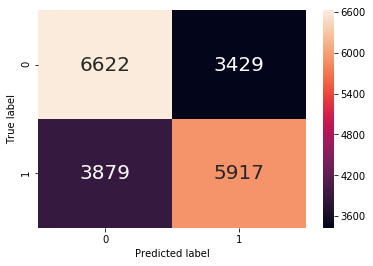

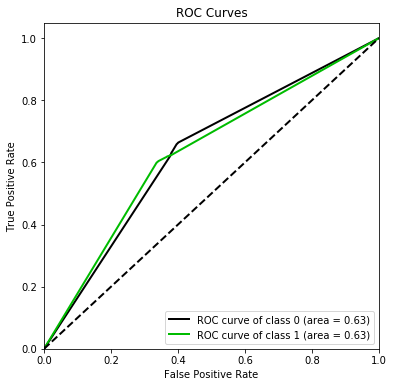

              precision    recall  f1-score   support

          no       0.63      0.66      0.64     10051
         yes       0.63      0.60      0.62      9796

   micro avg       0.63      0.63      0.63     19847
   macro avg       0.63      0.63      0.63     19847
weighted avg       0.63      0.63      0.63     19847



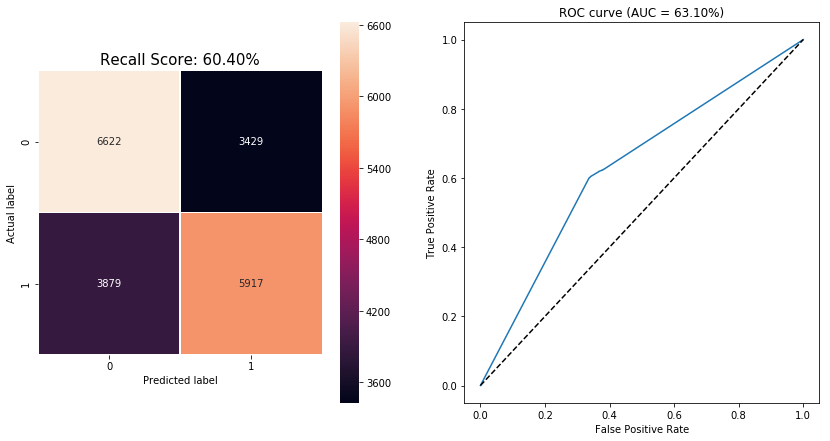

In [44]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

# DT performance
print('Accuracy -DT: ', accuracy_score(y_test, y_pred)) 
print('Recall - DT: ', recall_score(y_test, y_pred)) 
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True, annot_kws={"size": 20})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


plot_roc_curve(y_test, y_prob, figsize=(6,6), curves=('each_class'))
plt.show()


show_summary(model, X_test, y_test)
plot_conf_ROC(model, X_test, y_test)

    plt.subplot(121)
    sns.heatmap(conf, annot=True, fmt=".0f", linewidths=.5, square = True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0:.2f}%'.format(100*accuracy)
    plt.title(all_sample_title, size = 15)

## 4.2.1 Decision Tree - Grid Search

In [ ]:
# testing DT with various parameters
minleaf_range = [1,2,3,5]
minsplit_range = [2,5,10,15,20]
maxdepth_range = [2,3,5,8,10]

param_grid = {'min_samples_leaf': minleaf_range,
              'min_samples_split': minsplit_range,
              'max_depth': maxdepth_range}

grid_search = GridSearchCV(DecisionTreeClassifier(criterion = "entropy", random_state = 100), param_grid=param_grid, scoring="recall")

grid_search = grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(best_params)

In [ ]:
model_tuned = tree.DecisionTreeClassifier(**best_params)
model_tuned = model_tuned.fit(X_train, y_train)
y_prob_tuned = model_tuned.predict_proba(X_test)
y_pred_tuned = model_tuned.predict(X_test)

print('Accuracy - DT Grid Search: ', accuracy_score(y_test, y_pred_tuned)) 
print('Recall - DT Grid Search: ', recall_score(y_test, y_pred_tuned)) 
print(classification_report(y_test, y_pred_tuned))

sns.heatmap(confusion_matrix(y_test, y_pred_tuned), fmt='g', annot=True, annot_kws={"size": 20})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

plot_roc_curve(y_test, y_prob_tuned, figsize=(6,6), curves=('each_class'))
plt.show()

## 4.2.2 Decision Tree - Random Search

In [ ]:
# testing DT with various parameters
minleaf_range = [1,2,3,5]
minsplit_range = [2,5,10,15,20]
maxdepth_range = [2,3,5,8,10]

param_grid = {'min_samples_leaf': minleaf_range,
              'min_samples_split': minsplit_range,
              'max_depth': maxdepth_range}

grid_search = GridSearchCV(DecisionTreeClassifier(criterion = "entropy", random_state = 100), param_grid=param_grid, scoring="recall")

grid_search = grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(best_params)

In [ ]:
param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3,5,10,12],
    "max_features": sp_randint(1, 11),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(1,16)
}


random_search = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(), 
    param_distributions=param_dist, 
    n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1, 
    scoring="recall"
)

random_search = random_search.fit(X_train, y_train)
best_params = random_search.best_params_

print(best_params)

In [ ]:
model_tuned = tree.DecisionTreeClassifier(**best_params)
model_tuned = model_tuned.fit(X_train, y_train)
y_prob_tuned = model_tuned.predict_proba(X_test)
y_pred_tuned = model_tuned.predict(X_test)

print('Accuracy - DT Random Search: ', accuracy_score(y_test, y_pred_tuned)) 
print('Recall - DT Random Search: ', recall_score(y_test, y_pred_tuned)) 
print(classification_report(y_test, y_pred_tuned))

sns.heatmap(confusion_matrix(y_test, y_pred_tuned), fmt='g', annot=True, annot_kws={"size": 20})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

plot_roc_curve(y_test, y_prob_tuned, figsize=(6,6), curves=('each_class'))
plt.show()

In [ ]:
# Train the final model
tree = DecisionTreeClassifier(criterion = "entropy", 
                              random_state = 100, 
                              max_depth=10, 
                              min_samples_leaf=1,
                              min_samples_split=2)
tree.fit(X_train, y_train)

# function for class predicting based on model
def predict_class(model, x_test):
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:,1]
    
    return y_pred, y_prob
# predict and print report
def show_summary(model, x_test, y_test):
    from sklearn.metrics import classification_report
    y_pred, y_prob = predict_class(model, x_test)

    model.report = classification_report(y_test, y_pred, target_names=["no","yes"])
    print(model.report)
    
# plot confusion table and ROC curve
def plot_conf_ROC(model, x_test, y_test):
    from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
    import seaborn as sns
    
    # calculate class predictions and probabilities
    y_pred, y_prob = predict_class(model, x_test)
    
    # accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # confusion matrix
    conf = confusion_matrix(y_test, y_pred)

    # visualize conf table and ROC curve
    plt.figure(figsize=(14,7))

    plt.subplot(121)
    sns.heatmap(conf, annot=True, fmt=".0f", linewidths=.5, square = True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0:.2f}%'.format(100*accuracy)
    plt.title(all_sample_title, size = 15)

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    plt.subplot(122)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title('ROC curve (AUC = {0:.2f}%)'.format(100*auc_score))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

# displays decision tree rules
#def display_tree(tree_cls, features):
#    dot_data = tree.export_graphviz(tree_cls, out_file=None, feature_names=features, filled=True, rounded=True, special_characters=True)
#    graph = graphviz.Source(dot_data)
#    return graph

show_summary(tree, X_test, y_test)
plot_conf_ROC(tree, X_test, y_test)
#display_tree(tree, )



## 4.3 Random forest

In [ ]:
# testing RF with various parameters
minleaf_range = [1,2,5]
minsplit_range = [2,5,8,10]
maxdepth_range = [12,15,18,21]
boot_range = [True, False]

param_grid = {'min_samples_leaf': minleaf_range,
              'min_samples_split': minsplit_range,
              'max_depth': maxdepth_range,
              'bootstrap': boot_range}

grid_search = GridSearchCV(RandomForestClassifier(criterion = "entropy", 
                                                  random_state = 100,
                                                  n_estimators=500), 
                           param_grid=param_grid, 
                           scoring="recall",
                           n_jobs = -1)

# print the best params
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

In [ ]:
# Train the final model
forest = RandomForestClassifier(criterion = "entropy", 
                                random_state = 100,
                                n_estimators=2000,
                                max_depth=18, 
                                min_samples_leaf=5,
                                min_samples_split=2,
                                bootstrap=True,
                                n_jobs = -1)
forest.fit(X_train, y_train)

show_summary(forest, X_test, y_test)
plot_conf_ROC(forest, X_test, y_test)

## Feature Importance

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# fit an Extra Trees model to the data
extra = ExtraTreesClassifier(criterion = "entropy", 
                             random_state = 100,
                             n_estimators=2000,
                             max_depth=12, 
                             min_samples_leaf=1,
                             min_samples_split=10,
                             bootstrap=False)
extra.fit(X_train, Y_train)

# display the relative importance of each attribute
plt.bar(np.arange(1,14), height=extra.feature_importances_)

In [ ]:
labels = list(df)
labels_features = labels[:-1]

# table with features and their importances
importance = pd.DataFrame(extra.feature_importances_, np.array(labels_features))
importance.columns = ['importance']
importance.sort_values(by='importance', ascending=False)

In [ ]:
dtree = dtreeplt(
    model=decision_tree,
    feature_names=X_train.columns,
    target_names=y.values
)
dtree.view()